# Downloading and Pre-Processing ASOS Weather Data in Python
*[Florian Roscheck](https://www.linkedin.com/in/florianroscheck/), 2020-03-07*

This notebook demonstrates how to download and pre-process ASOS weather data in Python. ASOS data is meteorological data that is collected at airport stations around the world and typically includes information about temperature, humidity, wind direction, and wind speed. ASOS data is also known as AWOS data or METAR data.

## Downloading Data from Mesonet

ASOS data is distributed through various sources, one being [Iowa State University](https://mesonet.agron.iastate.edu/ASOS/). In this section, we use Python to download data from Mesonet through Python.

We are specifically interested in data in and around San Diego, CA, although other data can be downloaded from Mesonet in the same way. Daryl Herzmann provides a Python example in his [GitHub repository](https://github.com/akrherz/iem/blob/ff666d2e1122d133900ef8adcf71c39cf49b8aeb/scripts/asos/iem_scraper_example.py) that we adapt use here:

In [244]:
import json
import time
import datetime
import pandas as pd
from urllib.request import urlopen

# Number of attempts to download data
MAX_ATTEMPTS = 6
# HTTPS here can be problematic for installs that don't have Lets Encrypt CA
SERVICE = "http://mesonet.agron.iastate.edu/cgi-bin/request/asos.py?"


def download_data(uri):
    """Fetch the data from the IEM

    The IEM download service has some protections in place to keep the number
    of inbound requests in check.  This function implements an exponential
    backoff to keep individual downloads from erroring.

    Args:
      uri (string): URL to fetch

    Returns:
      string data
    """
    attempt = 0
    while attempt < MAX_ATTEMPTS:
        try:
            data = urlopen(uri, timeout=300).read().decode("utf-8")
            if data is not None and not data.startswith("ERROR"):
                return data
        except Exception as exp:
            print("download_data(%s) failed with %s" % (uri, exp))
            time.sleep(5)
        attempt += 1

    print("Exhausted attempts to download, returning empty data")
    return ""


def get_stations_from_filelist(filename):
    """Build a listing of stations from a simple file listing the stations.

    The file should simply have one station per line.
    """
    stations = []
    for line in open(filename):
        stations.append(line.strip())
    return stations


def get_stations_from_networks(limit_state: None):
    """Build a station list by using a bunch of IEM networks."""
    stations = {}
    states = """AK AL AR AZ CA CO CT DE FL GA HI IA ID IL IN KS KY LA MA MD ME
     MI MN MO MS MT NC ND NE NH NJ NM NV NY OH OK OR PA RI SC SD TN TX UT VA VT
     WA WI WV WY"""
    
    networks = []
    for state in states.split():
        if limit_state and state != limit_state:
            continue
        else:
            networks.append("%s_ASOS" % (state,))

    for network in networks:
        # Get metadata
        uri = (
            "https://mesonet.agron.iastate.edu/" "geojson/network/%s.geojson"
        ) % (network,)
        data = urlopen(uri)
        jdict = json.load(data)
        for site in jdict["features"]:
            stations[site["properties"]["sid"]] = site['geometry']['coordinates']
    return stations

def download_one_station(station_name, 
                         start_date_utc, 
                         end_date_utc, 
                         fields, 
                         path):
    if not fields:
        fields = ['all']
        
    service = SERVICE
        
    for field in fields:
        service += 'data={}&'.format(field)
    
    service += "tz=Etc/UTC&format=comma&latlon=yes&"

    service += start_date_utc.strftime("year1=%Y&month1=%m&day1=%d&")
    service += end_date_utc.strftime("year2=%Y&month2=%m&day2=%d&")

    uri = "%s&station=%s" % (service, station_name)
    print("Downloading: %s..." % (station_name,), end='')
    
    data = download_data(uri)
    outfn = "%s/%s_%s_%s.csv" % (
        path,
        station_name,
        start_date_utc.strftime("%Y%m%d%H%M"),
        end_date_utc.strftime("%Y%m%d%H%M"),
    )
    with open(outfn, "w") as f:
        f.write(data)
    print('done and saved to {}.'.format(outfn))

### Visualize Available Stations in California

As a first step, let's see which stations are available for download in California and where they are located.

In [245]:
# Download stations in California

ca_stations = get_stations_from_networks('CA')
ca_stations_df = pd.DataFrame(ca_stations, index=['lon', 'lat']).T
ca_stations_df = ca_stations_df[['lat', 'lon']]

print('Downloaded {} stations.'.format(ca_stations_df.shape[0]))

ca_stations_df.head()

Downloaded 153 stations.


,lat,lon
AAT,41.4914,-120.5644
ACV,40.9781,-124.1086
AUN,38.9548,-121.0817
AVX,33.4050,-118.4158
BFL,35.4344,-119.0542


In [246]:
# Plot all stations in California on a map

import folium

map_center = ca_stations_df.median()

m = folium.Map(location=map_center, tiles='Stamen Terrain', zoom_start=5)
for station_name, coords in ca_stations_df.iterrows():
    folium.Marker(coords, popup=station_name).add_to(m)
    
m

Southern California seems to have a dense network of stations. To find stations in San Diego, let's zoom in on the map above and identify stations of interest. The station IDs should be visible in a popup when you click on the station marker.

### Download a Subset of Available Stations

After zooming in, we have identified the following stations in San Diego that we would like to download data for: `SAN`, `MYF`, and `NKX`. Now let's download their data from Mesonet.

In [247]:
# Download stations

selected_stations = ['SAN', 'MYF', 'NKX']

start_date = datetime.datetime(2000, 1, 1)
end_date = datetime.datetime(2020, 3, 7)

# ´fields´ can have different values, we are interested in the following:
#   - tmpc: Temperature in degree celsius
#   - drct: Wind direction in degrees
#   - sped: Speed in miles per hour
fields = ['tmpc', 'drct', 'sped']

for station_name in selected_stations:
    download_one_station(station_name, start_date, end_date, fields, '../data')

Downloading: SAN...done and saved to ../data/SAN_200001010000_202003070000.csv.
Downloading: MYF...done and saved to ../data/MYF_200001010000_202003070000.csv.
Downloading: NKX...done and saved to ../data/NKX_200001010000_202003070000.csv.


Great, we downloaded data for the 3 stations!

## Pre-Processing Station Data

To be able to easily use the station data, we need to preprocess it. Let's have a quick look at the data to see what we should take care of to make it usable. At the end of this section, we will have removed all irrelevant data from the downloaded files and transformed them into Parquet format, which is great for time series data.

In [248]:
# Imports

import pandas as pd

data_files = ['../data/SAN_200001010000_202003070000.csv',
              '../data/MYF_200001010000_202003070000.csv',
              '../data/NKX_200001010000_202003070000.csv']

In [249]:
# Read first couple of lines to see what file looks like

with open(data_files[0]) as f:
    for nx in range(10):
        print('{}: {}'.format(nx+1, f.readline()), end='')

1: #DEBUG: Format Typ    -> comma
2: #DEBUG: Time Period   -> 2000-01-01 00:00:00+00:00 2020-03-07 00:00:00+00:00
3: #DEBUG: Time Zone     -> Etc/UTC
4: #DEBUG: Data Contact   -> daryl herzmann akrherz@iastate.edu 515-294-5978
5: #DEBUG: Entries Found -> -1
6: station,valid,lon,lat,tmpc,drct,sped
7: SAN,2000-01-01 00:51,-117.1845,32.7339,14.40,220.00,6.90
8: SAN,2000-01-01 01:51,-117.1845,32.7339,13.90,230.00,10.35
9: SAN,2000-01-01 02:51,-117.1845,32.7339,12.20,190.00,8.05
10: SAN,2000-01-01 03:51,-117.1845,32.7339,11.70,190.00,4.60


It looks as if the first 5 lines of the file contain information that we need to skip when we import the file into pandas. Also, we probably do not need information about the `station`, `lon`, or `lat` in the imported data, since we already have this information. Let's try to import only the relevant information from the file with pandas.

In [250]:
# Read data into pandas

data = pd.read_csv(data_files[0], skiprows=5, usecols=fields+['valid'])
data.head()

,valid,tmpc,drct,sped
0,2000-01-01 00:51,14.40,220.00,6.90
1,2000-01-01 01:51,13.90,230.00,10.35
2,2000-01-01 02:51,12.20,190.00,8.05
3,2000-01-01 03:51,11.70,190.00,4.60
4,2000-01-01 04:51,11.70,110.00,4.60


In [251]:
# Show data info

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 606089 entries, 0 to 606088
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   valid   606089 non-null  object
 1   tmpc    606089 non-null  object
 2   drct    606089 non-null  object
 3   sped    606089 non-null  object
dtypes: object(4)
memory usage: 18.5+ MB


In [252]:
# Check if there are any suspicious values

data['tmpc'].value_counts()[:5]

M        399044
15.00     10046
20.00      9683
17.20      8687
17.80      8367
Name: tmpc, dtype: int64

`M` stands for *missing*. We need to replace those values with an appropriate Pythonic value.

In [253]:
# Replace `M` with None

data = data.replace({'M': None})

The data type of the dataframe value columns also does not look right (it is `object`), we should cast them to `float`.

In [254]:
# Cast value columns to floats

for col in ['tmpc', 'drct', 'sped']:
    data[col] = data[col].astype(float)

We need to make the `valid` field the index and adjust for the time difference between UTC and San Diego time. After all, we are focusing on San Diego in this example.

We also want to convert the values in the `sped` column from miles per hour to meters per second. In addition, we would like to rename the columns of the dataframe.

In [255]:
# Fix index columns

data.index = pd.to_datetime(data['valid'])
data.index.name = 'time'
data = data.drop(columns=['valid'])

data.head()

,tmpc,drct,sped
time,,,
2000-01-01 00:51:00,14.4,220.0,6.90
2000-01-01 01:51:00,13.9,230.0,10.35
2000-01-01 02:51:00,12.2,190.0,8.05
2000-01-01 03:51:00,11.7,190.0,4.60
2000-01-01 04:51:00,11.7,110.0,4.60


In [256]:
# Adjust index time zone

import pytz

san_diego_time = pytz.timezone('America/Los_Angeles')
data.index = data.index.tz_localize(pytz.utc).tz_convert(san_diego_time).tz_localize(None)

data.head()

,tmpc,drct,sped
time,,,
1999-12-31 16:51:00,14.4,220.0,6.90
1999-12-31 17:51:00,13.9,230.0,10.35
1999-12-31 18:51:00,12.2,190.0,8.05
1999-12-31 19:51:00,11.7,190.0,4.60
1999-12-31 20:51:00,11.7,110.0,4.60


In [257]:
# Convert speed column from miles per hour to meters per second

data['sped'] = data['sped']*0.44704

In [258]:
# Rename columns

data = data.rename(columns={'tmpc': 'tmp', 'drct': 'dir', 'sped': 'spd'})

data.head()

,tmp,dir,spd
time,,,
1999-12-31 16:51:00,14.4,220.0,3.084576
1999-12-31 17:51:00,13.9,230.0,4.626864
1999-12-31 18:51:00,12.2,190.0,3.598672
1999-12-31 19:51:00,11.7,190.0,2.056384
1999-12-31 20:51:00,11.7,110.0,2.056384


Before saving the data, let's quickly make sure that we got the time zone right. With meteorological data, there is a neat trick you can pull off: Just look at the temperature profile. It gets cold at night and warm by day.

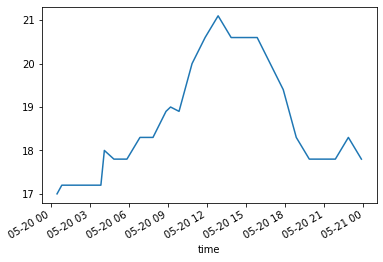

In [259]:
# Plot temperature profile over a day

data['2006-05-20']['tmp'].plot()

That looks about right!

To speed up the process with all stations and finally save the data, let's write a quick function to do what we did in this section:

In [260]:
# Write method to preprocess an asos file with methods from above

from pathlib import Path
from matplotlib import pyplot as plt

def preprocess_and_save_asos_file(path):
    print('Now preprocessing {}...'.format(path), end='')
    
    data = pd.read_csv(path, skiprows=5, usecols=fields+['valid'])
    
    data = data.replace({'M': None})
    
    for col in ['tmpc', 'drct', 'sped']:
        data[col] = data[col].astype(float)
        
    data.index = pd.to_datetime(data['valid'])
    data.index.name = 'time'
    data = data.drop(columns=['valid'])
    
    data.index = data.index.tz_localize(pytz.utc).tz_convert(san_diego_time).tz_localize(None)
    
    data['sped'] = data['sped']*0.44704
    
    data = data.rename(columns={'tmpc': 'tmp', 'drct': 'dir', 'sped': 'spd'})
    
    data['2006-05-20']['tmp'].plot()
    plt.show()
    
    print(data.head())
    
    save_path = Path(path).with_suffix('.parquet')
    data.to_parquet(save_path)
    
    print('done and saved to {}.\n'.format(save_path))
    
    return data

Finally, let's preprocess all files and save their metadata.

Now preprocessing ../data/SAN_200001010000_202003070000.csv...

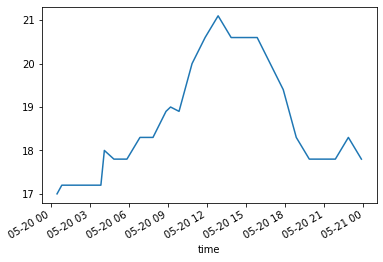

                      tmp    dir       spd
time                                      
1999-12-31 16:51:00  14.4  220.0  3.084576
1999-12-31 17:51:00  13.9  230.0  4.626864
1999-12-31 18:51:00  12.2  190.0  3.598672
1999-12-31 19:51:00  11.7  190.0  2.056384
1999-12-31 20:51:00  11.7  110.0  2.056384
done and saved to ../data/SAN_200001010000_202003070000.parquet.

Now preprocessing ../data/MYF_200001010000_202003070000.csv...

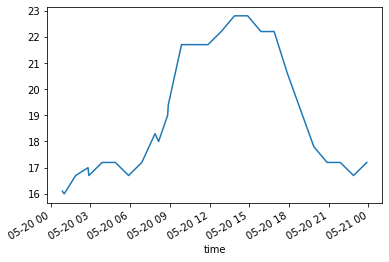

                      tmp    dir       spd
time                                      
1999-12-31 16:53:00  12.2  240.0  3.598672
1999-12-31 17:53:00  12.2  230.0  3.084576
1999-12-31 18:53:00  11.1  200.0  3.598672
1999-12-31 19:53:00  10.0  200.0  3.084576
1999-12-31 20:53:00  10.0  140.0  2.056384
done and saved to ../data/MYF_200001010000_202003070000.parquet.

Now preprocessing ../data/NKX_200001010000_202003070000.csv...

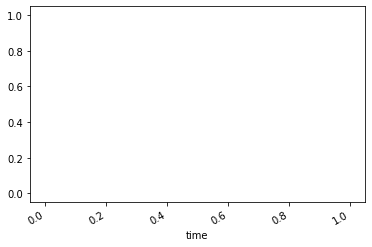

                      tmp    dir       spd
time                                      
1999-12-31 16:56:00  11.7  260.0  3.084576
1999-12-31 18:56:00  10.6  230.0  3.084576
1999-12-31 19:56:00   8.9  210.0  2.570480
1999-12-31 20:56:00   8.3  160.0  3.084576
1999-12-31 21:56:00   9.4  190.0  3.084576
done and saved to ../data/NKX_200001010000_202003070000.parquet.



In [261]:
# Preprocess all files

import json

preprocessed_data = {}

for station_name, file_name in zip(selected_stations, data_files):
    station_meta = ca_stations[station_name]
    with open(Path(file_name).with_suffix('.json'), 'w') as f:
        json.dump(station_meta, f)
    
    preprocessed_data[station_name] = preprocess_and_save_asos_file(file_name)

This is it! Now we can load the data and explore it!

## Data Exploration

Although not the main focus of this workbook, it is always interesting to do some data exploration. As an example, let's see if we can create a 12x24 mean wind speed matrix without much effort.

This kind of matrix is interesting when looking at wind speeds, because it is easy to see any wind speed trends over the day and month. Personally I find it very fun to see how weather/wind patterns can differ throughout the day and the year. Finally, would it not be also fun to see how the three weather stations compare? Enough of the talking, let's see what we can do!

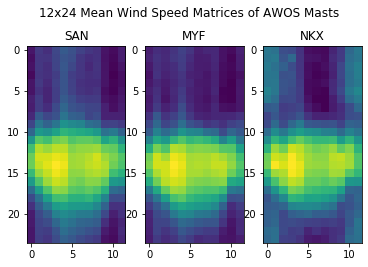

In [262]:
fig, axes = plt.subplots(1, len(preprocessed_data))

for ax, (station_name, data) in zip(axes, preprocessed_data.items()):
    spd_12x24 = pd.pivot_table(data, 
                               index=data.index.hour, 
                               columns=data.index.month, 
                               values='spd', 
                               aggfunc='mean')
    ax.imshow(spd_12x24.values)
    ax.title.set_text(station_name)
    
fig.suptitle('12x24 Mean Wind Speed Matrices of AWOS Masts')

plt.show()

The temporal patterns of all masts look pretty similar, with high wind speeds during the day and low wind speeds during the night. Mast NKX has a more pronounced pattern between different times of the year, with the winter months having higher wind speeds than the summer months.

Before reading too much into the plots, be aware of the following:
- We did not spend time on cleaning the data yet and there may or may not be some outliers influencing this mean estimate.
- The plots do not have the same color scale, so you cannot compare actual wind speeds between the plots.
- We have not accounted for data gaps. A better comparison can be achieved with forcing concurrent data steps.
    
In summary, there are many more steps to do for a proper analysis of the wind speed and other weather data. But, it was great to see how easy it is to get some interesting insight with freely available weather data and Python.